<h1 id="undersampling_for_multiclass_classification_of_accidents">Undersampling for Multi-class Classification of Automobile Accidents in Seattle, Washington<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7f202c7c2e50>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = "../Collisions.csv"
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [11]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [12]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [13]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [14]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [15]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [16]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [17]:
# Create DataFrame of categorical columns.
df_categorical = df_converted.select_dtypes(include="category")

<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [18]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,Clear,Dry,Daylight
5,1,Rear Ended,Clear,Dry,Daylight
6,1,Other,Clear,Wet,Daylight
8,1,Sideswipe,Overcast,Dry,Daylight


In [19]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   SEVERITYCODE   171872 non-null  category
 1   COLLISIONTYPE  171872 non-null  category
 2   WEATHER        171872 non-null  category
 3   ROADCOND       171872 non-null  category
 4   LIGHTCOND      171872 non-null  category
dtypes: category(5)
memory usage: 2.1 MB


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [20]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [21]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [22]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [23]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [24]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class 1 size =', class_1_size)
print('class 2 size =', class_2_size)
print('class 2b size =', class_2b_size)
print('class 3 size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority class size =', minority_class_size)

class 1 size = 113082
class 2 size = 55521
class 2b size = 2941
class 3 size = 328

minority class size = 328


<h2 id='undersampling_without_replacement'>Undersampling the non-minority classes without replacement<\h2>

In [28]:
sample_size_class_1 = np.int(class_3_size)
sample_size_class_2 = np.int(class_3_size)
sample_size_class_2b = np.int(class_3_size)
sample_size_class_3 = np.int(class_3_size)

In [29]:
# For each non-minority class, undersample this class by resampling it for a number of samples equal to the size of the minority class.
df_class_1_sampled = df_class_1.sample(n=sample_size_class_1, replace=False, weights=None, axis='index', random_state=seed)
df_class_2_sampled = df_class_2.sample(n=sample_size_class_2, replace=False, weights=None, axis='index', random_state=seed)
df_class_2b_sampled = df_class_2b.sample(n=sample_size_class_2b, replace=False, weights=None, axis='index', random_state=seed)
df_class_3_sampled = df_class_3.sample(n=sample_size_class_3, replace=False, weights=None, axis='index', random_state=seed)

In [30]:
# Produce a new DataFrame by concatenating the minority class's DataFrame with the undersampled resamples of the non-minority classes.
df_balanced_not_shuffled = pd.concat([df_class_1_sampled, df_class_2_sampled, df_class_2b_sampled, df_class_3_sampled],  axis='index')

In [31]:
# Shuffle the new balanced DataFrame and store it for subsequent train/test splits.
df_balanced_undersampled = shuffle(df_balanced_not_shuffled, random_state=seed)

In [32]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced_undersampled["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b    328
2     328
1     328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [33]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced_undersampled["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [34]:
X = df_balanced_undersampled[["COLLISIONTYPE", "WEATHER", "ROADCOND", "LIGHTCOND"]]

We also define the data for the target variable, SEVERITYCODE, by the array y:

In [35]:
y = df_balanced_undersampled["SEVERITYCODE"].to_numpy()

## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [36]:
# Create a OneHotEncoder and fit it to the features.
# Transform the data into a sparse matrix by passing the parameter sparse=True by default.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True)
X = encoder.fit_transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.categories_)

Fitting OneHotEncoder to training data...
Completed in 0.04992187302559614 seconds.
[array(['Angles', 'Cycles', 'Head On', 'Left Turn', 'Other', 'Parked Car',
       'Pedestrian', 'Rear Ended', 'Right Turn', 'Sideswipe'],
      dtype=object), array(['Clear', 'Fog/Smog/Smoke', 'Other', 'Overcast', 'Partly Cloudy',
       'Raining', 'Severe Crosswind', 'Snowing'], dtype=object), array(['Dry', 'Ice', 'Snow/Slush', 'Standing Water', 'Wet'], dtype=object), array(['Dark - No Street Lights', 'Dark - Street Lights Off',
       'Dark - Street Lights On', 'Dawn', 'Daylight', 'Dusk', 'Other'],
      dtype=object)]


In [37]:
type(X)

scipy.sparse.csr.csr_matrix

In [38]:
X.shape

(1312, 30)

In [39]:
y.shape

(1312,)

<h2 id="logistic_regression_undersampling">Building a Logistic Regression Model through Undersampling without Replacement<\h2>

In [40]:
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


In [41]:
t0 = default_timer()
kfold_cv = KFold(n_splits=10)
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, n_jobs=-1, random_state=seed))
scoring = ['f1_macro', 'neg_log_loss','precision_macro', 'recall_macro']
logistic_regression_undersampling_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Logistic regression through undersampling score keys:", sorted(logistic_regression_undersampling_scores.keys()))
print_elapsed_time(t0)

Logistic regression through undersampling score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_neg_log_loss', 'test_precision_macro', 'test_recall_macro']
Elapsed time is 7.388762192975264 seconds.


In [42]:
for key in sorted(logistic_regression_undersampling_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_undersampling_scores[key]), np.std(logistic_regression_undersampling_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_undersampling_scores[key]), sep='')
        print()

fit_time: mean = 0.344330, std = 0.026741
fit_time :[0.34493852 0.33985448 0.3631413  0.32680249 0.32428479 0.31371427
 0.33303809 0.36320925 0.40960717 0.32470846]

score_time: mean = 0.028966, std = 0.003520
score_time :[0.0280273  0.03279972 0.0321393  0.0245471  0.03192639 0.02455115
 0.03243399 0.03233624 0.02436757 0.02652931]

test_f1_macro: mean = 0.456573, std = 0.026373
test_f1_macro :[0.41909265 0.43203951 0.43382989 0.48547599 0.43142751 0.47725336
 0.49297497 0.45356886 0.49052169 0.44954375]

test_neg_log_loss: mean = -1.183958, std = 0.054360
test_neg_log_loss :[-1.28803498 -1.174397   -1.14350713 -1.1908906  -1.14963405 -1.14859417
 -1.13474169 -1.28247922 -1.13572084 -1.19158311]

test_precision_macro: mean = 0.474423, std = 0.029661
test_precision_macro :[0.44805556 0.44181141 0.44325461 0.49528428 0.44024725 0.504329
 0.49325216 0.45443661 0.51530718 0.50825052]

test_recall_macro: mean = 0.467763, std = 0.029716
test_recall_macro :[0.42730457 0.43470023 0.44404652 0

<h2 id="svm_undersampling">Building a Support Vector Machine through Undersampling without Replacement<\h2>

In [43]:
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


In [44]:
t0 = default_timer()
kfold_cv = KFold(n_splits=10)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=1000))
scoring = ['f1_macro', 'precision_macro', 'recall_macro']
linear_svc_undersampling_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Logistic regression through undersampling score keys:", sorted(logistic_regression_undersampling_scores.keys()))
print_elapsed_time(t0)

Logistic regression through undersampling score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_neg_log_loss', 'test_precision_macro', 'test_recall_macro']
Elapsed time is 1.9436848309705965 seconds.


In [45]:
for key in sorted(linear_svc_undersampling_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_undersampling_scores[key]), np.std(linear_svc_undersampling_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_undersampling_scores[key]), sep='')
        print()

fit_time: mean = 0.334000, std = 0.092107
fit_time :[0.54764867 0.39539599 0.37555838 0.40305829 0.31293201 0.29540777
 0.24073291 0.24397731 0.26450539 0.26078582]

score_time: mean = 0.028484, std = 0.011720
score_time :[0.04909086 0.05004859 0.03465629 0.01686406 0.02663255 0.02485538
 0.01694727 0.02437019 0.02404118 0.01733136]

test_f1_macro: mean = 0.454789, std = 0.021836
test_f1_macro :[0.45149585 0.44451146 0.43976699 0.47235056 0.40741111 0.47565238
 0.48283557 0.44544229 0.47810498 0.45031472]

test_precision_macro: mean = 0.475662, std = 0.028517
test_precision_macro :[0.49401738 0.45678054 0.45298574 0.48837769 0.41806739 0.50744388
 0.48415831 0.44760101 0.50635859 0.50083333]

test_recall_macro: mean = 0.470923, std = 0.027241
test_recall_macro :[0.46523787 0.44846342 0.45162228 0.49968925 0.41354102 0.50278092
 0.49893603 0.46542011 0.49454205 0.4689951 ]



## Sanity Check: Manually Split the Undersampled Data into Training and Testing Sets

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=os.times()[4])#seed)

In [47]:
range(len(logistic_regression_undersampling_scores['estimator']))

range(0, 10)

Model 0:
lr_clf mean accuracy = 0.52
Jaccard scores by class  [0.56666667 0.39393939 0.17073171 0.34090909]
              precision    recall  f1-score   support

           1     0.8095    0.6538    0.7234        26
           2     0.5000    0.6500    0.5652        20
          2b     0.3500    0.2500    0.2917        28
           3     0.4545    0.5769    0.5085        26

    accuracy                         0.5200       100
   macro avg     0.5285    0.5327    0.5222       100
weighted avg     0.5267    0.5200    0.5150       100

Confusion matrices normalized over the true conditions:
Confusion matrices normalized over the predicted conditions:
Model 1:
lr_clf mean accuracy = 0.51
Jaccard scores by class  [0.6        0.38235294 0.125      0.33333333]
              precision    recall  f1-score   support

           1     0.8182    0.6923    0.7500        26
           2     0.4815    0.6500    0.5532        20
          2b     0.2941    0.1786    0.2222        28
           3   

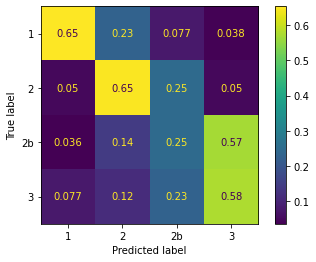

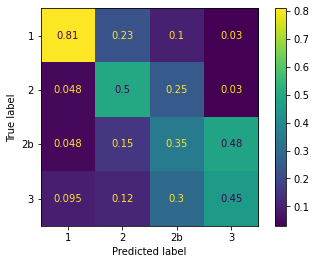

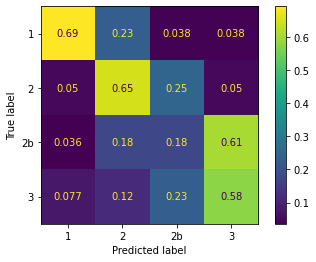

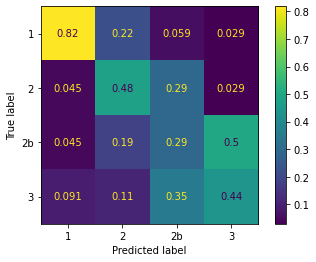

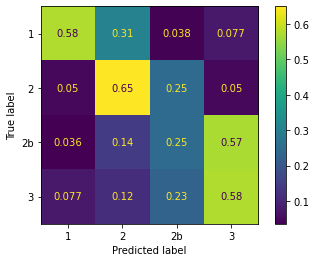

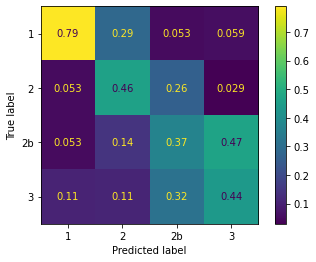

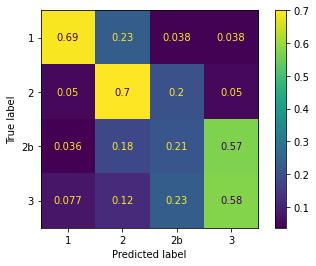

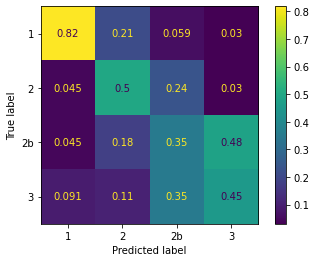

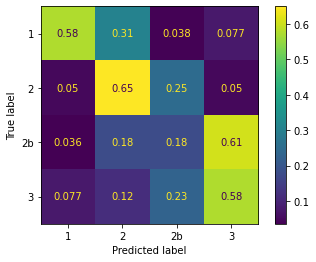

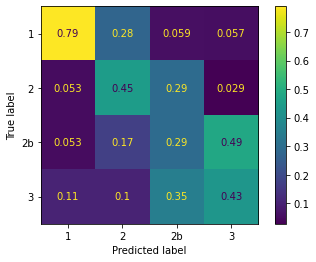

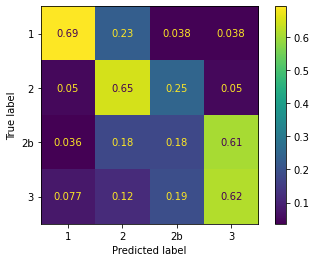

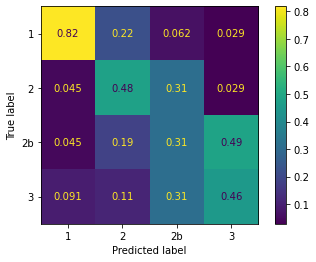

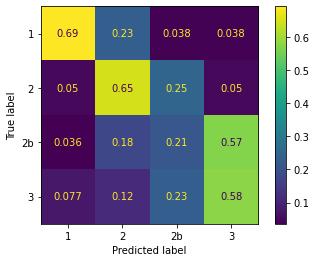

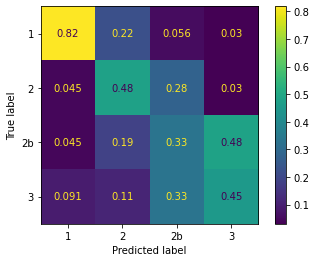

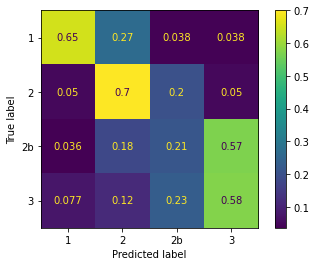

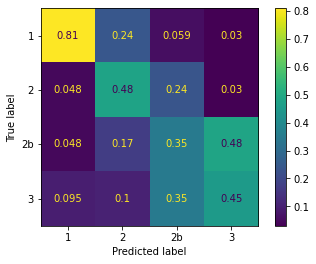

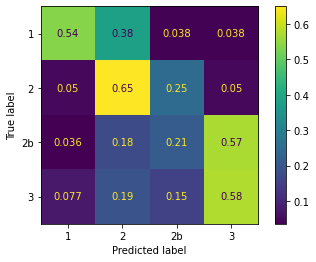

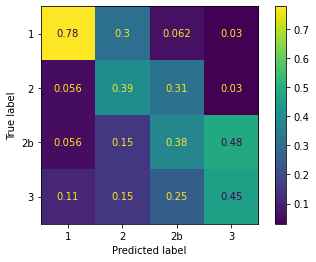

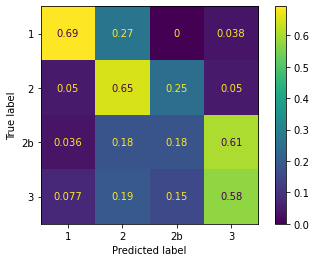

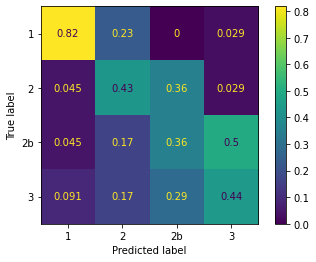

In [48]:
# For each logistic regression classifier in the cross-validation, print the Jaccard score for each class.
for index, lr_clf in zip(range(len(logistic_regression_undersampling_scores['estimator'])), logistic_regression_undersampling_scores['estimator']):
    lr_clf_score = lr_clf.score(X_test, y_test)
    y_test_predicted = lr_clf.predict(X_test)
    lr_clf_jaccard_scores = jaccard_score(y_test, y_test_predicted, average=None, labels=['1', '2', '2b', '3'])
    print('Model %d:' % (index))
    print('lr_clf mean accuracy =', lr_clf_score)
    print('Jaccard scores by class ', lr_clf_jaccard_scores)
    print(classification_report(y_test, y_test_predicted, labels=['1', '2', '2b', '3'], target_names=['1', '2', '2b', '3'], digits=4))
    print("Confusion matrices normalized over the true conditions:")
    plot_confusion_matrix(lr_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='true')
    print("Confusion matrices normalized over the predicted conditions:")
    plot_confusion_matrix(lr_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='pred')

In [49]:
range(len(linear_svc_undersampling_scores['estimator']))

range(0, 10)

Model 0:
linear_svc_clf mean accuracy = 0.49
Jaccard scores by class  [0.51724138 0.38235294 0.14634146 0.31914894]
              precision    recall  f1-score   support

           1     0.8333    0.5769    0.6818        26
           2     0.4815    0.6500    0.5532        20
          2b     0.3158    0.2143    0.2553        28
           3     0.4167    0.5769    0.4839        26

    accuracy                         0.4900       100
   macro avg     0.5118    0.5045    0.4935       100
weighted avg     0.5097    0.4900    0.4852       100

Confusion matrices normalized over the true conditions:
Confusion matrices normalized over the predicted conditions:
Model 1:
linear_svc_clf mean accuracy = 0.49
Jaccard scores by class  [0.53333333 0.37142857 0.125      0.32608696]
              precision    recall  f1-score   support

           1     0.8000    0.6154    0.6957        26
           2     0.4643    0.6500    0.5417        20
          2b     0.2941    0.1786    0.2222        28

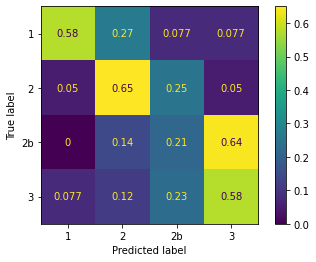

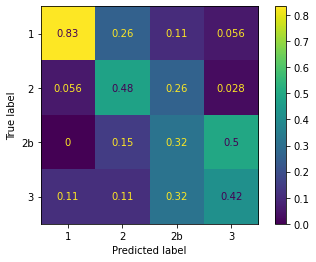

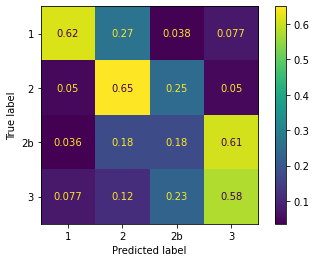

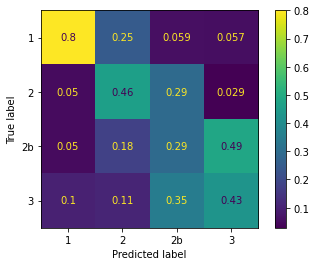

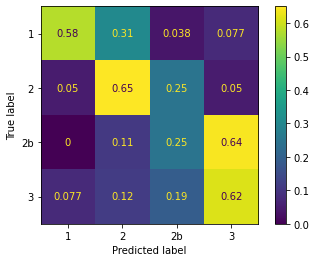

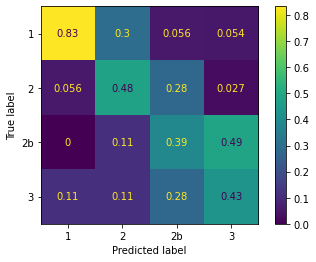

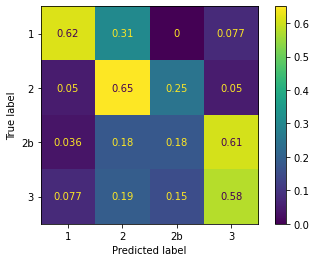

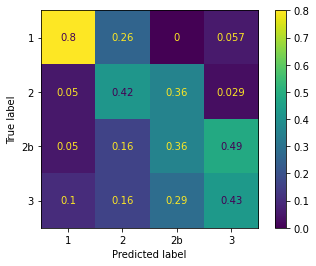

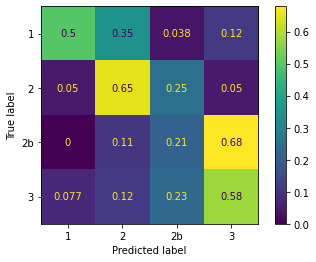

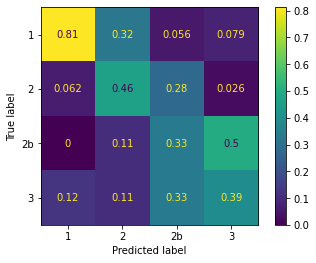

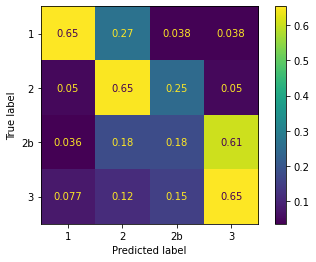

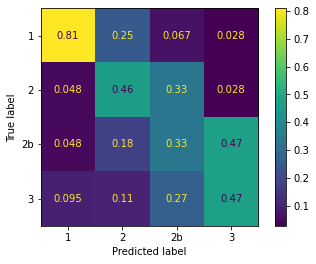

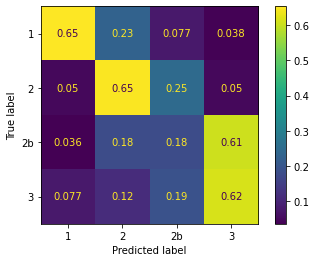

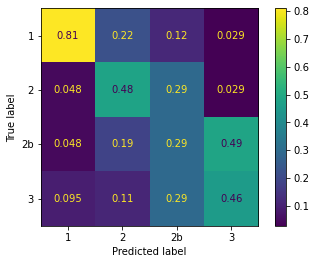

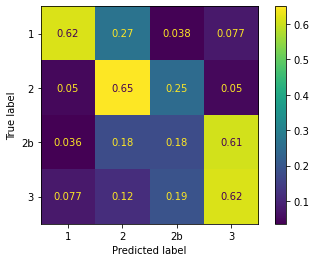

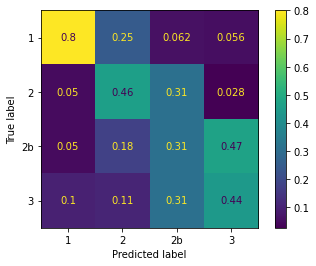

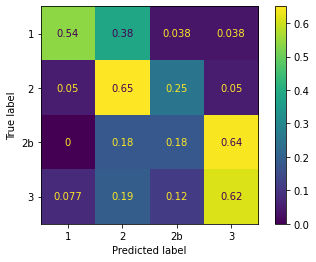

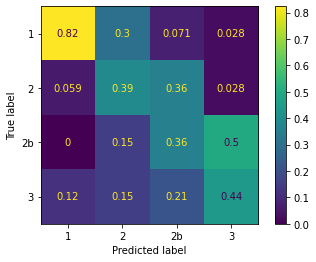

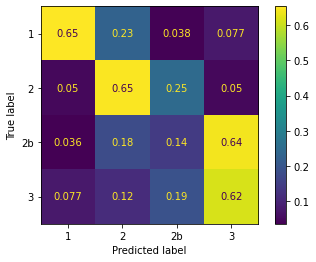

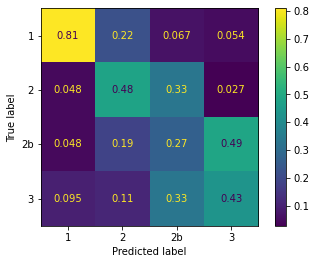

In [50]:
# For each support vector machine classifier in the cross-validation, print the Jaccard score for each class.
for index, linear_svc_clf in zip(range(len(linear_svc_undersampling_scores['estimator'])), linear_svc_undersampling_scores['estimator']):
    linear_svc_score = linear_svc_clf.score(X_test, y_test)
    y_test_predicted = linear_svc_clf.predict(X_test)
    linear_svc_jaccard_scores = jaccard_score(y_test, y_test_predicted, average=None, labels=['1', '2', '2b', '3'])
    print('Model %d:' % (index))
    print('linear_svc_clf mean accuracy =', linear_svc_score)
    print('Jaccard scores by class ', linear_svc_jaccard_scores)
    print(classification_report(y_test, y_test_predicted, labels=['1', '2', '2b', '3'], target_names=['1', '2', '2b', '3'], digits=4))
    print("Confusion matrices normalized over the true conditions:")
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='true')
    print("Confusion matrices normalized over the predicted conditions:")
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='pred')

In [51]:
print_elapsed_time()

Elapsed time is 423.5579136029701 seconds.
